In [33]:
%matplotlib inline

import dateutil.parser
import datetime
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.contrib import learn

from sklearn.metrics import mean_squared_error


# from data_processing import generate_data, load_csvdata

In [34]:
# -*- coding: utf-8 -*-
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.python.framework import dtypes
from tensorflow.contrib import learn as tflearn
from tensorflow.contrib import layers as tflayers


def lstm_model(num_units, rnn_layers, dense_layers=None, learning_rate=0.1, optimizer='Adagrad'):
    """
    Creates a deep model based on:
        * stacked lstm cells
        * an optional dense layers
    :param num_units: the size of the cells.
    :param rnn_layers: list of int or dict
                         * list of int: the steps used to instantiate the `BasicLSTMCell` cell
                         * list of dict: [{steps: int, keep_prob: int}, ...]
    :param dense_layers: list of nodes for each layer
    :return: the model definition
    """

    def lstm_cells(layers):
        if isinstance(layers[0], dict):
            return [tf.contrib.rnn.DropoutWrapper(
                tf.contrib.rnn.BasicLSTMCell(
                    layer['num_units'], state_is_tuple=True
                ),
                layer['keep_prob']
            ) if layer.get('keep_prob') else tf.contrib.rnn.BasicLSTMCell(
                    layer['num_units'],
                    state_is_tuple=True
                ) for layer in layers
            ]
        return [tf.contrib.rnn.BasicLSTMCell(steps, state_is_tuple=True) for steps in layers]

    def dnn_layers(input_layers, layers):
        if layers and isinstance(layers, dict):
            return tflayers.stack(input_layers, tflayers.fully_connected,
                                  layers['layers'],
                                  activation=layers.get('activation'),
                                  dropout=layers.get('dropout'))
        elif layers:
            return tflayers.stack(input_layers, tflayers.fully_connected, layers)
        else:
            return input_layers

    def _lstm_model(X, y):
        stacked_lstm = tf.contrib.rnn.MultiRNNCell(lstm_cells(rnn_layers), state_is_tuple=True)
        x_ = tf.unstack(X, axis=1, num=num_units)
        output, layers = tf.contrib.rnn.static_rnn(stacked_lstm, x_, dtype=dtypes.float32)
        output = dnn_layers(output[-1], dense_layers)
        prediction, loss = tflearn.models.linear_regression(output, y)
        train_op = tf.contrib.layers.optimize_loss(
            loss, tf.contrib.framework.get_global_step(), optimizer=optimizer,
            learning_rate=learning_rate)
        return prediction, loss, train_op

    return _lstm_model


In [35]:
LOG_DIR = './ops_logs/lstm_weather'
TIMESTEPS = 10
RNN_LAYERS = [{'num_units': 5}]
DENSE_LAYERS = [10, 10]
TRAINING_STEPS = 100000
BATCH_SIZE = 100
PRINT_STEPS = TRAINING_STEPS / 100

# Transform QCLCD Data Function

In [36]:
# downloaded weather data from http://www.ncdc.noaa.gov/qclcd/QCLCD
def load_weather_frame(filename):
    #load the weather data and make a date
    data_raw = pd.read_csv(filename, dtype={'Time': str, 'Date': str})
    data_raw['WetBulbCelsius'] = data_raw['WetBulbCelsius'].astype(float)
    times = []
    for index, row in data_raw.iterrows():
        _t = datetime.time(int(row['Time'][:2]), int(row['Time'][:-2]), 0) #2153
        _d = datetime.datetime.strptime( row['Date'], "%Y%m%d" ) #20150905
        times.append(datetime.datetime.combine(_d, _t))

    data_raw['_time'] = pd.Series(times, index=data_raw.index)
    df =  pd.DataFrame(data_raw, columns=['_time','WetBulbCelsius'])
    return df.set_index('_time')


# Load The Data as CSV 
This is QCLCD data for PDX. It is what will be used to train the model.

In [37]:
import pandas as pd

In [38]:
df = pd.read_csv("data.csv")

In [39]:
df.head()

,time,Deg C,Degrees,ms
0,01-Jan-93 5:30 AM,13.8,24.4,4.99
1,01-Jan-93 6:30 AM,14.9,23.2,4.79
2,01-Jan-93 7:30 AM,17.8,23.9,3.92
3,01-Jan-93 8:30 AM,20.7,40.1,6.27
4,01-Jan-93 9:30 AM,22.8,46.7,7.81


In [40]:
X = df["Degrees"][:10000]

In [41]:
y = new_df["Unnamed: 0"][:10000]

In [42]:
y

0          0
1          1
2          2
3          3
4          4
5          5
6          6
7          7
8          8
9          9
10        10
11        11
12        12
13        13
14        14
15        15
16        16
17        17
18        18
19        19
20        20
21        21
22        22
23        23
24        24
25        25
26        26
27        27
28        28
29        29
        ... 
9970    9970
9971    9971
9972    9972
9973    9973
9974    9974
9975    9975
9976    9976
9977    9977
9978    9978
9979    9979
9980    9980
9981    9981
9982    9982
9983    9983
9984    9984
9985    9985
9986    9986
9987    9987
9988    9988
9989    9989
9990    9990
9991    9991
9992    9992
9993    9993
9994    9994
9995    9995
9996    9996
9997    9997
9998    9998
9999    9999
Name: Unnamed: 0, Length: 10000, dtype: int64

In [14]:
# scale values to reasonable values and convert to float
# data_weather = load_weather_frame("preprocessing.csv")
# X, y = load_csvdata(data_weather, TIMESTEPS, seperate=False)

# Run The Model and Fit Predictions

In [43]:
śregressor = learn.SKCompat(learn.Estimator(
    model_fn=lstm_model(
        TIMESTEPS,
        RNN_LAYERS,
        DENSE_LAYERS
    ),
    model_dir=LOG_DIR
))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021385BAF128>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': './ops_logs/lstm_weather'}


In [46]:
# create a lstm instance and validation monitor
validation_monitor = learn.monitors.ValidationMonitor(X, y,
                                                     every_n_steps=PRINT_STEPS,
                                                     early_stopping_rounds=1000)
regressor.fit(X, y,
              monitors=[validation_monitor],
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS)

predicted = regressor.predict(X)

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


ValueError: Dimension must be 10 but is 1 for 'unstack' (op: 'Unpack') with input shapes: [?,1].

In [45]:
#not used in this example but used for seeing deviations
rmse = np.sqrt(((predicted - y['test']) ** 2).mean(axis=0))

score = mean_squared_error(predicted, y['test'])
print ("MSE: %f" % score)

NameError: name 'predicted' is not defined

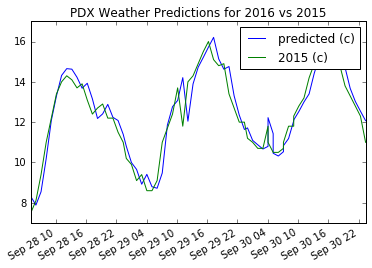

In [8]:
# plot the data
all_dates = data_weather.index.get_values()

fig, ax = plt.subplots(1)
fig.autofmt_xdate()

predicted_values = predicted.flatten() #already subset
predicted_dates = all_dates[len(all_dates)-len(predicted_values):len(all_dates)]
predicted_series = pd.Series(predicted_values, index=predicted_dates)
plot_predicted, = ax.plot(predicted_series, label='predicted (c)')

test_values = y['test'].flatten()
test_dates = all_dates[len(all_dates)-len(test_values):len(all_dates)]
test_series = pd.Series(test_values, index=test_dates)
plot_test, = ax.plot(test_series, label='2015 (c)')

xfmt = mdates.DateFormatter('%b %d %H')
ax.xaxis.set_major_formatter(xfmt)

# ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d %H')
plt.title('PDX Weather Predictions for 2016 vs 2015')
plt.legend(handles=[plot_predicted, plot_test])
plt.show()